In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geoip2.database
import myLogReader as mlr
import re
import os
import sys
import datetime as dt

%matplotlib inline

## Automate - Read and Prep log data into DF

In [14]:
logsPath = '../data/logs'
geoLiteIPDBPath = '../data/GeoLite2-City_20181009/GeoLite2-City.mmdb'

#Create a myLogReader object
myLogReader = mlr.log()
#Open Reader
myLogReader.openReader(geoLiteIPDBPath)

In [16]:
for i in range(2,4):
    print ('AggregatedData_week_%d.csv' % i)
    df =  myLogReader.readLogs(logsPath,7)
    df.to_csv('../data/AggregatedData_week_%d.csv' % i)

AggregatedData_week_2.csv
../data/logs\u_ex171230.log
../data/logs\u_ex171231.log
../data/logs\u_ex180101.log
../data/logs\u_ex180102.log
../data/logs\u_ex180103.log
../data/logs\u_ex180104.log
../data/logs\u_ex180105.log
AggregatedData_week_3.csv
../data/logs\u_ex180106.log
../data/logs\u_ex180107.log
../data/logs\u_ex180108.log
../data/logs\u_ex180109.log
../data/logs\u_ex180110.log
../data/logs\u_ex180111.log
../data/logs\u_ex180112.log


In [4]:
#Close Reader
myLogReader.closeReader()

In [8]:
df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count
calendar-year-week,,,,,,,,,,
2017-50,925,415,89497,52520170.0,38500,7784,27741,15472,80440,9057
2017-51,866,386,81378,44703569.0,39664,6585,21274,13855,72925,8453
2017-52,475,179,30843,14199684.0,9978,553,14279,6033,27735,3108
2018-1,769,354,71528,42663674.0,31666,8049,19512,12301,64710,6818
2018-2,920,441,90093,63904084.0,38238,6166,23249,22440,79099,10994


## 2- Load PlacementSummary and Logs Data aggregated per week

In [35]:
log_aggregated_per_week_df = pd.read_csv('../data/LogsAggregatedData_per_week.csv')
log_aggregated_per_week_df.set_index('calendar-year-week',inplace=True)

In [36]:
log_aggregated_per_week_df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,Season,Month
calendar-year-week,,,,,,,,,,,,
2017-50,925,415,89497,52520170,38500,7784,27741,15472,80440,9057,WINTER,December
2017-51,866,386,81378,44703569,39664,6585,21274,13855,72925,8453,WINTER,December
2017-52,475,179,30843,14199684,9978,553,14279,6033,27735,3108,WINTER,December
2018-01,769,354,71528,42663674,31666,8049,19512,12301,64710,6818,WINTER,January
2018-02,920,441,90093,63904084,38238,6166,23249,22440,79099,10994,WINTER,January


In [9]:
placement_summary_df = pd.read_csv('../data/PlacementSummary.csv')
placement_summary_df.set_index('YearWeek',inplace=True)

In [10]:
placement_summary_df.head()

,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
YearWeek,,,,,
2017-50,246,48,234,238,8
2017-51,198,77,196,197,1
2017-52,116,3,115,116,0
2017-53,113,17,96,113,0
2018-01,113,4,111,113,0


In [37]:
log_and_placements_aggregated_per_week_df = log_aggregated_per_week_df.join(placement_summary_df)
log_and_placements_aggregated_per_week_df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,Season,Month,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
calendar-year-week,,,,,,,,,,,,,,,,,
2017-50,925,415,89497,52520170,38500,7784,27741,15472,80440,9057,WINTER,December,246,48,234,238,8
2017-51,866,386,81378,44703569,39664,6585,21274,13855,72925,8453,WINTER,December,198,77,196,197,1
2017-52,475,179,30843,14199684,9978,553,14279,6033,27735,3108,WINTER,December,116,3,115,116,0
2018-01,769,354,71528,42663674,31666,8049,19512,12301,64710,6818,WINTER,January,113,4,111,113,0
2018-02,920,441,90093,63904084,38238,6166,23249,22440,79099,10994,WINTER,January,159,7,159,159,0


In [38]:
log_and_placements_aggregated_per_week_df.isna().sum()

client-ip-unique-count               0
cs-username-unique-count             0
client-connections-count             0
time-taken(ms)-sum                   0
Chrome-count                         0
Firefox-count                        0
Other-count                          0
Safari-count                         0
Desktop-count                        0
Mobile-count                         0
Season                               0
Month                                0
PlacementCount                       0
PlacementCompletedCount              0
PlacementAllocatedInProgressCount    0
PlacementAllocatedCount              0
PlacementNotAllocatedCount           0
dtype: int64

In [39]:
log_and_placements_aggregated_per_week_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 2017-50 to 2018-40
Data columns (total 17 columns):
client-ip-unique-count               43 non-null int64
cs-username-unique-count             43 non-null int64
client-connections-count             43 non-null int64
time-taken(ms)-sum                   43 non-null int64
Chrome-count                         43 non-null int64
Firefox-count                        43 non-null int64
Other-count                          43 non-null int64
Safari-count                         43 non-null int64
Desktop-count                        43 non-null int64
Mobile-count                         43 non-null int64
Season                               43 non-null object
Month                                43 non-null object
PlacementCount                       43 non-null int64
PlacementCompletedCount              43 non-null int64
PlacementAllocatedInProgressCount    43 non-null int64
PlacementAllocatedCount              43 non-null int64
Placement

Current size: [20.0, 7.0]


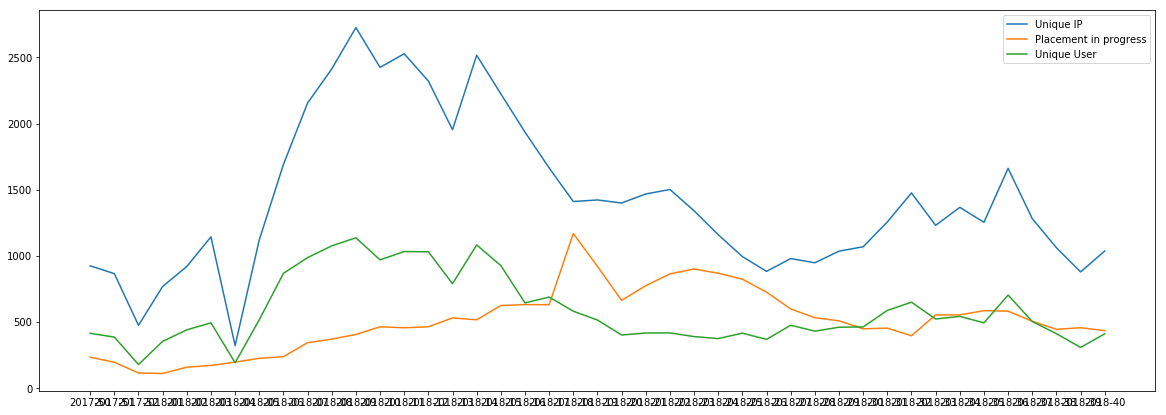

In [62]:
fig_size= plt.rcParams["figure.figsize"]

# Set figure width to 12 and height to 9
fig_size[0] = 20
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size


print ("Current size:",fig_size)

plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['client-ip-unique-count'],label="Unique IP")
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['PlacementAllocatedInProgressCount'],label="Placement in progress")
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['cs-username-unique-count'],label="Unique User")
plt.legend()

In [54]:
log_and_placements_aggregated_per_week_df.columns

Index(['client-ip-unique-count', 'cs-username-unique-count',
       'client-connections-count', 'time-taken(ms)-sum', 'Chrome-count',
       'Firefox-count', 'Other-count', 'Safari-count', 'Desktop-count',
       'Mobile-count', 'Season', 'Month', 'PlacementCount',
       'PlacementCompletedCount', 'PlacementAllocatedInProgressCount',
       'PlacementAllocatedCount', 'PlacementNotAllocatedCount'],
      dtype='object')

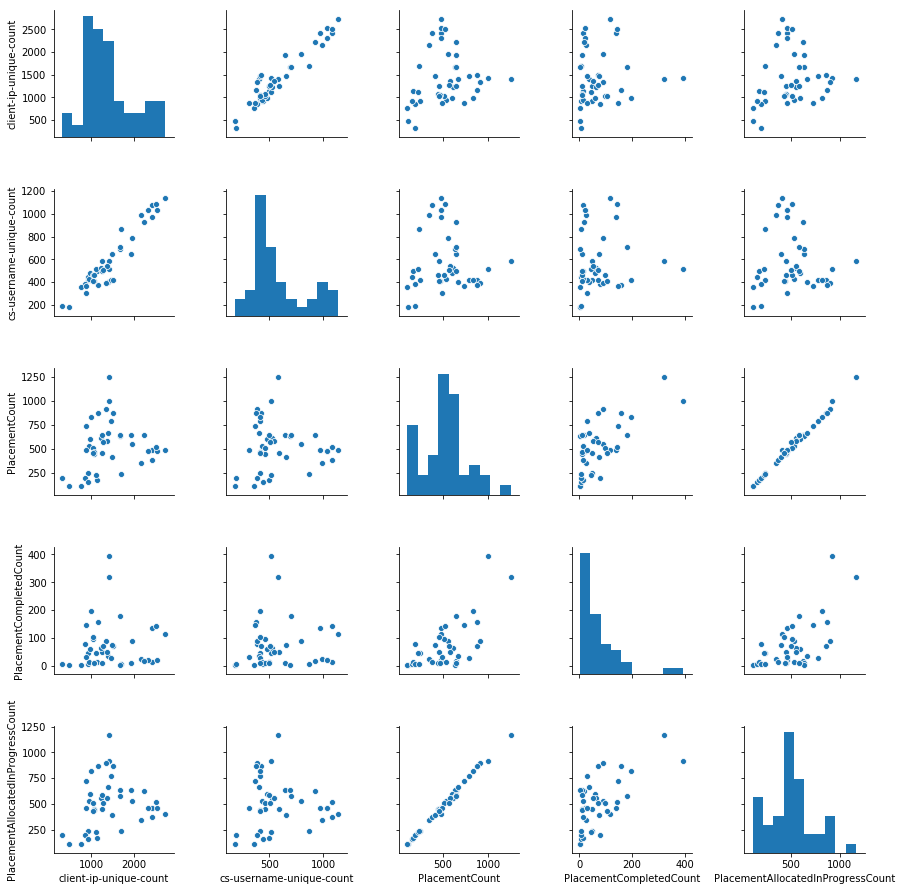

In [27]:
sns.pairplot(data=log_and_placements_aggregated_per_week_df
             ,vars=['client-ip-unique-count','cs-username-unique-count',
                    'PlacementCount', 'PlacementCompletedCount',
                    'PlacementAllocatedInProgressCount'])

## OTHER stuff


In [ ]:
df.info()

In [ ]:
df['client-ip'].describe()

In [65]:
log_and_placements_aggregated_per_week_df.loc[:, log_and_placements_aggregated_per_week_df.dtypes == object].describe()

,Season,Month
count,43,43
unique,3,10
top,SPRING,September
freq,15,5
